In [245]:
import os
import numpy as np
import sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [246]:
# given a directory and a list of the wanted classes, it parses all files
# in the directory that start with tracelog and extract the running times
# for the wanted classes
# the return structure is a list of lists, each list contains 4 elements
# [PErank, regionName, inclusiveTime, exclusiveTime]
#
# returnes list is ordered by PE rank

def getAllTimes( directory, wantedClasses):
    
    if not os.path.exists(traceDir):
        print("Given directory" + traceDir + "does not exist.\nAborting...")
        exit(-1)
    
    allTimes = []
    
    #all files in the directory
    for traceFile in os.listdir(traceDir):
        if not traceFile.startswith("tracelog"):
            continue

        thisPE = traceFile.split('.')[2]
        #print(thisPE)
        #print(traceFile)

        with open( os.path.join(traceDir,traceFile) ) as f:
            #line = f.readline()
            for line in f:

                splittedLine = line.split()
                #print(splittedLine)
                if len( splittedLine )<2: #this line does not contain data to gather
                    continue

                region = splittedLine[1]  #the format that scai uses
                regionClass = region.split('.')[0]

                #print( region )
                #gather for some interesting classes, not all
                if not regionClass in interestClasses: 
                    continue

                inclusInd = splittedLine.index('inclusive')
                inclTime = splittedLine[inclusInd+2][:-1]  #last char is a comma
                exclTime = splittedLine[-1]

                allTimes.append( [thisPE, region, inclTime, exclTime] )

    allTimes.sort( key= lambda x: int(x[0]) )
    
    return allTimes

In [271]:
# allTimes as returned from getAllTimes
# wantedPEs, a list of numbers for the wanted PEs to plot
# wantedRegions, the names of the wanted regions to plot

def plotWantedPEsWantedRegions( allTimes, wantedPEs, wantedRegions , plotPerWhat="pe", normalize=False, additionalData=[] ):
    numWantedPEs = len(wantedPEs)
    numWantedRegions = len(wantedRegions)
    
    wantedTimes = []

    # t[0] is the PErank, t[1] is the region name
    for t in allTimes:
        if ( int(t[0]) in wantedPEs) and (t[1] in wantedRegions):
            wantedTimes.append(t)

    timesPerPE = [ [] for i in range(numWantedPEs)]
    thisPE = -1
    #remember: in allTimes, data are sorted by PE rank. Also, the regions
    #appear in the same order
    for wt in wantedTimes:
        thisPE = int(wt[0]) 
        thisPEind = wantedPEs.index(thisPE)
        region = wt[1]
        inclTime = float(wt[2])
        timesPerPE[thisPEind].append( [region, inclTime] )
    
    assert( len(timesPerPE)==numWantedPEs )
    assert( len(timesPerPE[0])==numWantedRegions)
    
    missingFiles = 0 #count missing files
    
    # transpose in order to plot per region
    timePerRegion = { name:[] for name in wantedRegions}
    maxTimePerRegion = { name:0 for name in wantedRegions}
    
    for wt in timesPerPE:
        # a file for some PE may be missing
        if len(wt)==0:
            missingFiles += 1
            continue
        assert( len(wt)==numWantedRegions )
        
        for j in range(numWantedRegions):
            region = wt[j][0]
            value =  wt[j][1]
            if value>maxTimePerRegion[region]:
                maxTimePerRegion[region]=value
            timePerRegion[region].append( value )
            
    if normalize:
        for region in wantedRegions:
            timePerRegion[region] = [ x/maxTimePerRegion[region] for x in timePerRegion[region] ]
        if len(additionalData)>0:
            maxData = max(additionalData)
            additionalData = [x/maxData for x in additionalData]

        
    numExistingPEs = numWantedPEs-missingFiles
    assert( len(timePerRegion)==numWantedRegions )
    assert( len(timePerRegion[wantedRegions[0]])==numExistingPEs )
    
    ##
    ## plot
    ##
    
    fig, ax = plt.subplots(figsize=(15,10))
    plt.rcParams.update({'font.size': 25})
    
    marker = itertools.cycle((',', '+', '.','x', 'o', '*')) 
    
    if plotPerWhat=="pe":        
        plt.title( "Times per PE for " + str(numWantedRegions)+ " regions." )

        for x in timePerRegion:
            plt.plot( timePerRegion[x] , label=x, marker=next(marker) )

        plt.xticks( np.arange(0, numPEs, 1), wantedPEs, rotation=0, fontsize=16 )
        
    elif plotPerWhat=="region":
        plt.title( "Times per region for " +str(numWantedPEs)+" PEs"  )

        for i in range(numWantedPEs):
            plt.plot( [float(x[1]) for x in timesPerPE[i]] , label=wantedPEs[i], linewidth=2, marker=next(marker))

        xticks = [ x[0] for x in timesPerPE[0]] #wantedRegions
        plt.xticks( np.arange(0, len(xticks), 1), xticks, rotation=90, fontsize=16 )
    else:
        print("Wrong value for parameter 'plotPerWhat', acceptable values are 'pe' or 'region' ")
        exit(-1)
    
    if len(additionalData)>0:
        plt.plot(additionalData, label="additional data")

    plt.legend(fontsize=16)
    plt.show()
    

# Gather tracing information

In [234]:
traceDir = "/home/harry/supermuc/geographer_experiments/base-run/jobOutputs/"
#traceDir = "/home/harry/geographer/tracing_data/delaunay3D008M_k28/"

interestClasses = ['MultiLevel', 'LocalRefinement', 'ParcoRepart', 'GraphUtils', 'Communicator']

allTimes = getAllTimes( traceDir, interestClasses )
numPEs = max([int(x[0]) for x in allTimes])
allPEs = [i for i in range(numPEs)]

#get all timed region names
regionNames = sorted( set([x[1] for x in allTimes ]) ) 
numRegions = len(regionNames)   

#print all region names 
for i in range(0,numRegions):
    print(i, regionNames[i])

0 Communicator.MPI.all2all
1 Communicator.MPI.bcast
2 Communicator.MPI.exchangeByPlan
3 Communicator.MPI.gather
4 Communicator.MPI.max
5 Communicator.MPI.min
6 Communicator.MPI.scatter
7 Communicator.MPI.shift
8 Communicator.MPI.sum
9 Communicator.MPI.swap
10 Communicator.MPI.sync
11 GraphUtils.buildPartHalo
12 GraphUtils.getNodesWithNonLocalNeighbors
13 GraphUtils.getNodesWithNonLocalNeighbors_cache
14 GraphUtils.getPEGraph
15 GraphUtils.getPEGraph.buildMatrix
16 GraphUtils.getPEGraph.getOwners
17 GraphUtils.nonLocalNeighbors
18 LocalRefinement.distributedFMStep
19 LocalRefinement.distributedFMStep.copyToVector
20 LocalRefinement.distributedFMStep.loop
21 LocalRefinement.distributedFMStep.loop.checkPartition
22 LocalRefinement.distributedFMStep.loop.intro
23 LocalRefinement.distributedFMStep.loop.prepareRedist
24 LocalRefinement.distributedFMStep.loop.prepareSets
25 LocalRefinement.distributedFMStep.loop.prepareSets.nodeWeightExchange
26 LocalRefinement.distributedFMStep.loop.prepareS

## Get statistical info

In [235]:
allTimesPerRegion = []  #this is a list of lists
allVariancesPerRegion = []
allSTDPerRegion = []
allMeanTimePerRegion = []

#for all regions
for w in range(numRegions):
    thisRegionTimes = [ float(x[2]) for x in allTimes if x[1]==regionNames[w]]
    allTimesPerRegion.append( thisRegionTimes )
    allVariancesPerRegion.append( np.var(thisRegionTimes))
    allSTDPerRegion.append( np.std(thisRegionTimes))
    allMeanTimePerRegion.append( np.mean(thisRegionTimes) )

for i in np.argsort(allSTDPerRegion)[-10:]:
    print(i, regionNames[i])

29 LocalRefinement.distributedFMStep.loop.redistribute.updateDataStructures
28 LocalRefinement.distributedFMStep.loop.redistribute.generalDistribution
46 LocalRefinement.twoWayLocalFM
27 LocalRefinement.distributedFMStep.loop.redistribute
20 LocalRefinement.distributedFMStep.loop
10 Communicator.MPI.sync
33 LocalRefinement.getInterfaceNodes
35 LocalRefinement.getInterfaceNodes.communication
36 LocalRefinement.getInterfaceNodes.communication.syncswap
9 Communicator.MPI.swap


In [236]:
#get top 10 regions with the highest standart deviation
wantedRegions = np.argsort(allSTDPerRegion)[-10:].tolist()
wantedRegions = wantedRegions[::-1] #reverse

wantedRegionNames = []

for wr in wantedRegions:
    wantedRegionNames.append( regionNames[wr] )

## Plot mean for all PEs

In [237]:
inclTimesForWantedRegions=[]

for wr in wantedRegionNames:
    inclTimesForWantedRegions.append( [ float(x[2]) for x in allTimes if x[1]==wr ] )
    
PEidsForWantedRegion = [ int(x[0]) for x in allTimes if x[1]==wantedRegionNames[0]]

assert( len(inclTimesForWantedRegions[0])==len(PEidsForWantedRegion) )

In [238]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

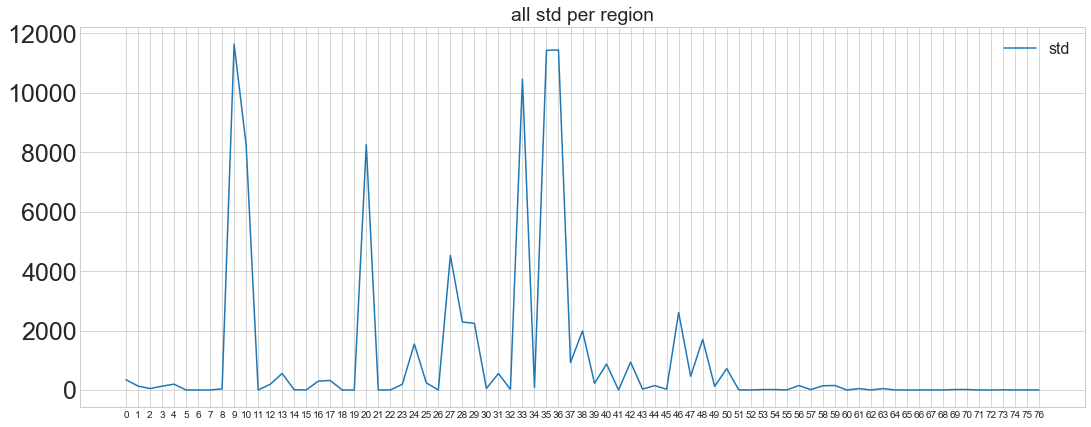

In [239]:
fig, ax = plt.subplots(figsize=(18,7))
plt.rcParams.update({'font.size': 16})

plt.title( "all std per region"  )

#plt.plot(allVariancesPerRegion, label='var')
plt.plot( allSTDPerRegion, label='std' )
#plt.plot( allMeanTimePerRegion, label='mean' )

#ax.set_yscale('log', basey=10)
plt.xticks(np.arange( 0, numRegions, 1.0), fontsize=10)
plt.legend()

plt.show()

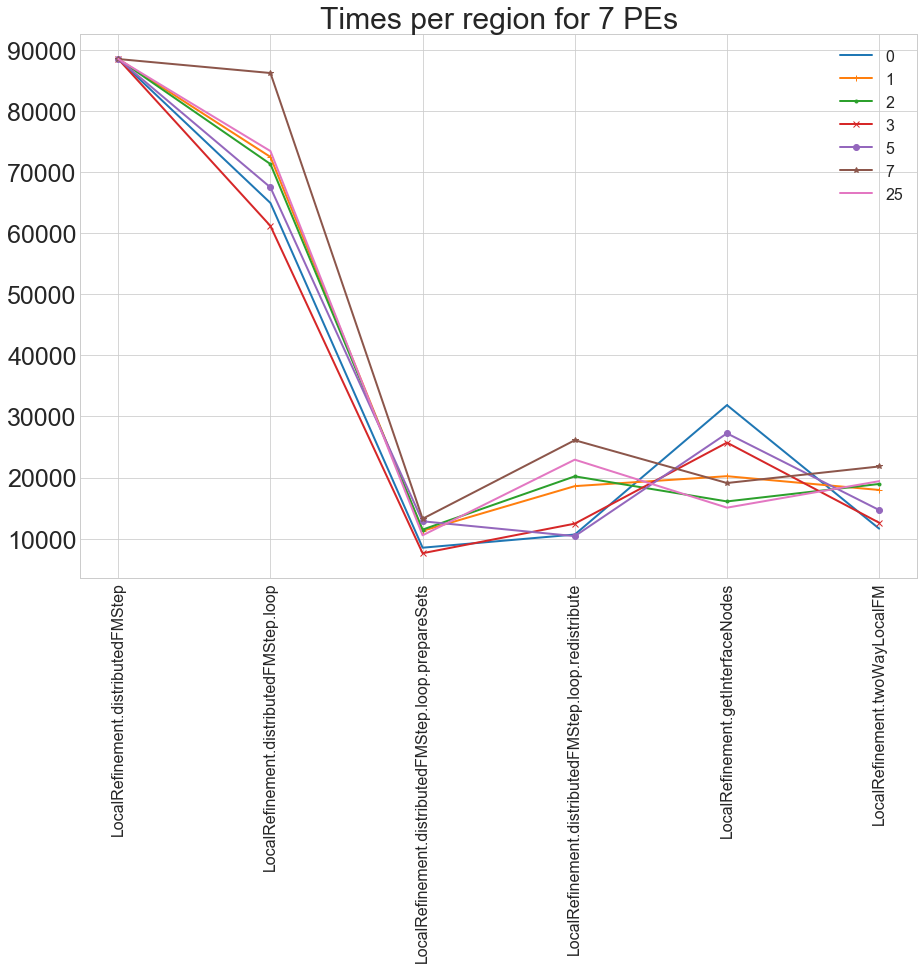

In [272]:
subsetPEs=[ 0, 1, 2, 3, 5, 7, 25 ]
wantedRegionNames = [ regionNames[18], regionNames[20], regionNames[33], regionNames[24], regionNames[46], regionNames[27] ]
plotWantedPEsWantedRegions( allTimes, subsetPEs, wantedRegionNames, "region")

['LocalRefinement.distributedFMStep.loop', 'LocalRefinement.distributedFMStep.loop.prepareSets', 'LocalRefinement.distributedFMStep.loop.redistribute', 'LocalRefinement.distributedFMStep.loop.updateLocalBorder', 'LocalRefinement.getInterfaceNodes', 'LocalRefinement.getInterfaceNodes.communication.syncswap', 'LocalRefinement.twoWayLocalFM']


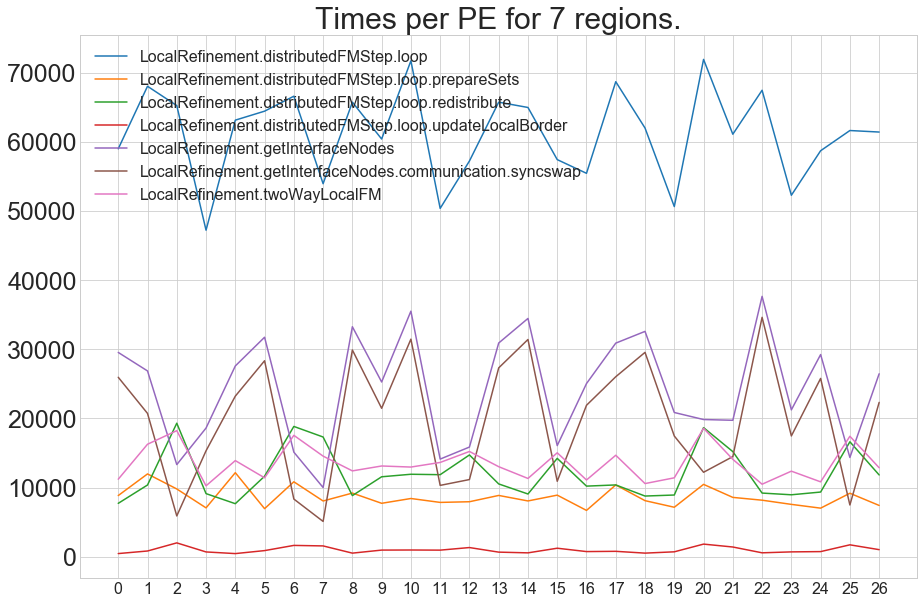

In [224]:
wantedRegionNames= [ regionNames[20], regionNames[24], regionNames[27], regionNames[31], regionNames[33], regionNames[36], regionNames[46],  ]
#wantedRegionNames= [regionNames[64],  regionNames[66], regionNames[67] ]

#wantedRegionNames = regionNames[26:29]

%store -r degScores
f = 3000
ampDeg = [x*f for x in degScores]

#wantedRegionNames.append( regionNames[53] )
print( wantedRegionNames )
plotWantedPEsWantedRegions( allTimes, allPEs, wantedRegionNames, "pe", False)

In [136]:
from scipy.stats.stats import pearsonr

region = "LocalRefinement.distributedFMStep.loop.redistribute"
regionTimes = [ float(x[2]) for x in allTimes if x[1]==region ]
print( pearsonr(regionTimes, degScores) )

region = "LocalRefinement.getInterfaceNodes"
regionTimes = [ float(x[2]) for x in allTimes if x[1]==region ]
print( pearsonr(regionTimes, degScores) )

region = "Communicator.MPI.swap"
regionTimesSwap = [ float(x[2]) for x in allTimes if x[1]==region ]
print( region, pearsonr(regionTimes, degScores) )

region = "Communicator.MPI.sync"
regionTimesSync = [ float(x[2]) for x in allTimes if x[1]==region ]
print( region,  pearsonr(regionTimes, degScores) )

syncAndSwap = [sum(x) for x in zip(regionTimesSwap, regionTimesSync)]
print( syncAndSwap )

(0.7239036406589138, 1.3362759913976343e-05)
(-0.4030270975578086, 0.03345998751338911)
Communicator.MPI.swap (-0.4030270975578086, 0.03345998751338911)
Communicator.MPI.sync (-0.4030270975578086, 0.03345998751338911)
[47402.576, 29846.194, 16821.934, 43308.157999999996, 17818.871, 36083.729, 27867.767, 10327.006, 43131.843, 38318.403, 36499.229999999996, 41103.333, 34317.169, 41971.652, 47022.566, 33578.814, 44844.678, 35472.775, 47924.83500000001, 38211.122, 27360.434, 38873.468, 45136.44, 39779.792, 43283.525, 17530.092, 36544.37, 44297.079999999994]


## Plot for wanted processor

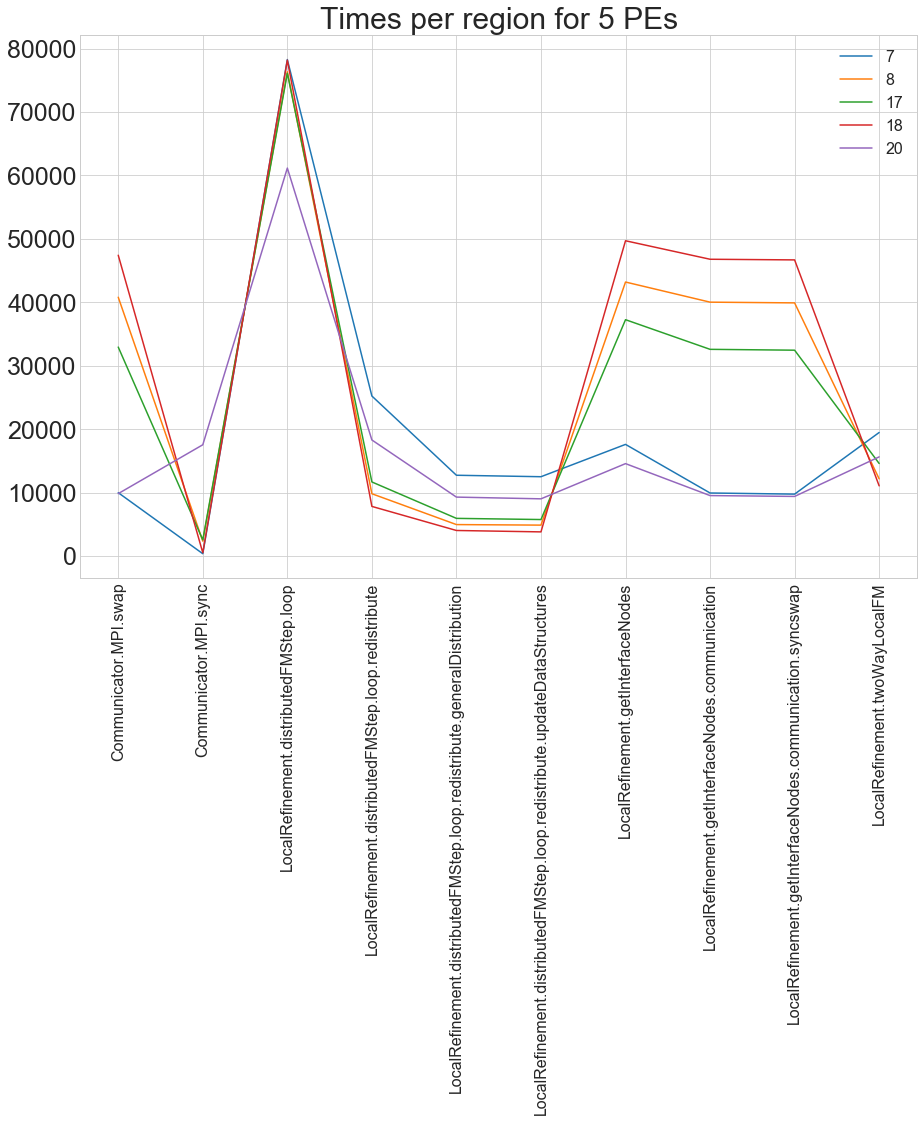

In [73]:
wantedPEs = [ 7, 8, 17, 18, 20]
plotWantedPEsWantedRegions( allTimes, wantedPEs, wantedRegionNames, "region")

In [ ]:
fig, ax = plt.subplots(figsize=(15,50))
plt.rcParams.update({'font.size': 25})

plt.title( "wantedPEs " +str(wantedPEs) )
plt.yticks( [j*(numWantedPES+1)+numWantedPES/2 for j in range(numRegions)], regionNames, rotation=0, fontsize=16 )

for i in range( numWantedPES ):
    assert( numRegions == len(allTimesForWantedPEs[i]) )
    
    yticksList = [j*(numWantedPES+1)+i for j in range(numRegions)]
    plt.barh( yticksList, allTimesForWantedPEs[i], label=wantedPEs[i] )

plt.legend()
plt.show

In [ ]:
def plotRawTimes( allTimes, wantedPEs, wantedRegions):
